## Reinforcement Learning Final Projet

Pre-amble: Results don't make sense to me lol

**Authors:**

**Due Date:**

---

### Dataset (from OpenBanditPipeline)

- **Type**: Synthetic contextual bandit  
- **Arms (actions)**: 10  
- **Context dimension**: 5 (features drawn from a standard normal distribution)  
- **Reward model**: Logistic function $q(x,a)$ with per-arm parameter vectors  
- **Behavior policy**: Uniformly random (each arm $a$ chosen with $p=1/10$  

### Policies evaluated

1. **LinUCB**  
   - Contextual UCB algorithm using a linear model for $q(x,a)$.  
   - Exploration bonus $\alpha$ controls the width of the confidence interval.  
   - Variants we tried:  
     - **LinUCB (α=0.0)** – pure greedy (no explicit exploration)  
     - **LinUCB (α=0.1)** – light exploration  
     - **LinUCB (α=0.5)** – 50% exploration, 50% exploitation

2. **LinTS**  
   - Linear Thompson Sampling:  

3. **Epsilon-Greedy (ε=0.1)**  
   - Fits a linear reward model.  
   - With probability $1-\varepsilon$ picks the arm with highest estimated $q(x,a)$; with probability $\varepsilon$ picks uniformly at random.

4. **Random**  
   - Always picks an arm uniformly at random (baseline for comparison).

---

Using this setup we want to understand how quickly and how well each strategy learns to choose the best arm. 

#### Library imports 

In [75]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# obp imports 
from obp.dataset import SyntheticBanditDataset, logistic_reward_function
from obp.policy import LinTS, LinUCB, LinEpsilonGreedy

from obp.ope import OffPolicyEvaluation, ReplayMethod
from obp.simulator import calc_ground_truth_policy_value, run_bandit_simulation

import warnings
warnings.filterwarnings('ignore')

### Experiment Parameters

In [105]:
# Set up experiment parameters (same as real sample dataset)
n_rounds = 10000      # sample size of logged bandit data
n_actions = 10        # number of actions
dim_context = 5       # dimensions of context vectors
n_sim = 50             # number of simulations to calculate ground truth policy values
random_state = 12345

np.random.seed(random_state)

In [106]:
print(f"- Number of rounds: {n_rounds}")
print(f"- Number of actions: {n_actions}")
print(f"- Context dimension: {dim_context}")
print(f"- Ground truth simulations: {n_sim}")
print(f"- Random state: {random_state}")

- Number of rounds: 10000
- Number of actions: 10
- Context dimension: 5
- Ground truth simulations: 50
- Random state: 12345


In [117]:
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,         
    reward_function=logistic_reward_function,
    behavior_policy_function=None,
    random_state=random_state,
)
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)


In [118]:
# Get a batch of 5000 rounds for experimenting 
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=5000)

### Exploring the synthetic dataset

In [119]:
df = pd.DataFrame({
    'action': bandit_feedback['action'],
    'reward': bandit_feedback['reward'],
    'pscore': bandit_feedback['pscore'],  # propensity under the random policy
    **{f'ctx_{i}': bandit_feedback['context'][:, i]
       for i in range(bandit_feedback['context'].shape[1])}
})

In [120]:
print(df.shape)   # e.g. (5000, dim_context + 3)
print(df.head())

(5000, 8)
   action  reward  pscore     ctx_0     ctx_1     ctx_2     ctx_3     ctx_4
0       7       0     0.1  0.596036 -1.738798 -0.111939 -2.126629 -0.281510
1       2       1     0.1  0.024402  0.467063 -0.853573 -1.148835 -0.869262
2       1       0     0.1 -0.182031  0.459393 -1.384990 -0.354944 -0.855379
3       3       1     0.1  0.586328  0.135735  2.159366  1.359562  1.948423
4       6       1     0.1  1.299374  3.092279  0.549063 -0.915910 -0.023029


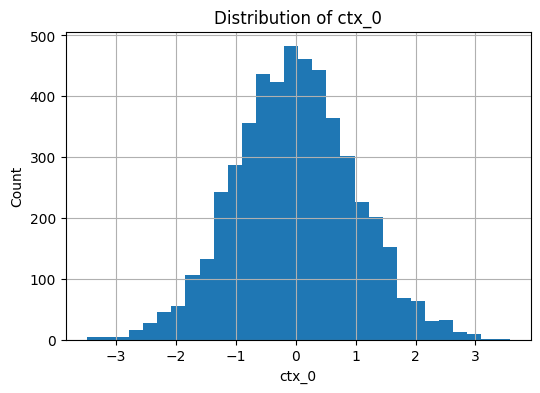

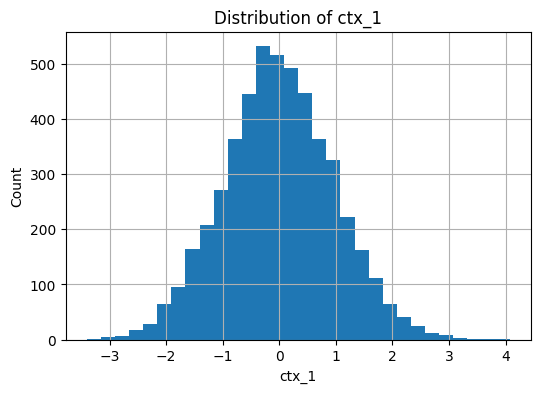

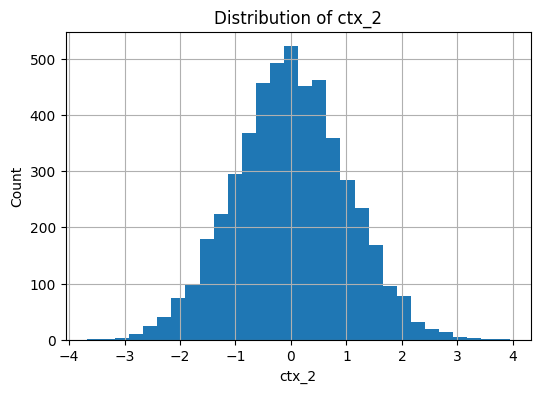

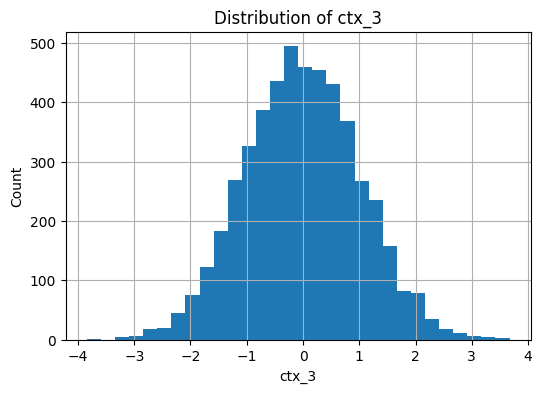

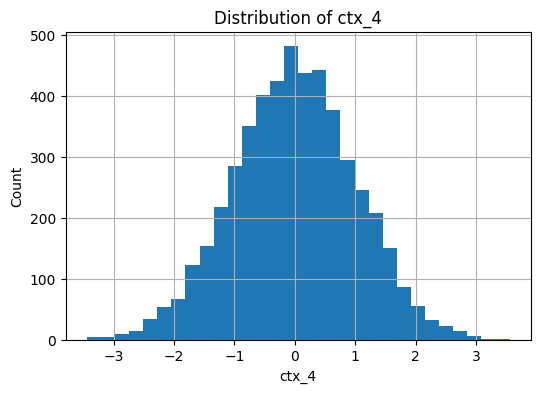

In [121]:
# context columns
context_cols = [c for c in df.columns if c.startswith('ctx_')]

# Check that the context columns are all normally distributed 
for col in context_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

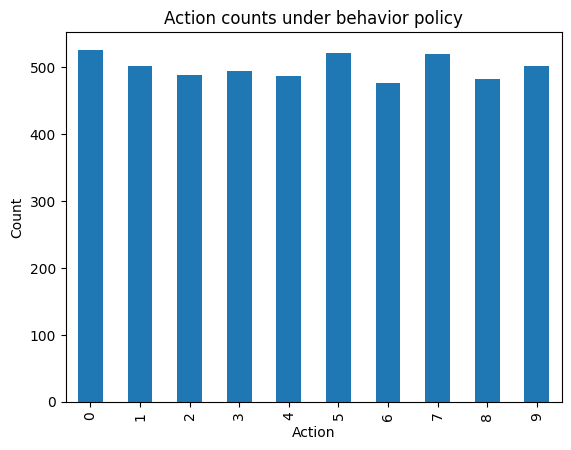

In [82]:
# Plot arm‐pull counts
df['action'].value_counts().sort_index()\
  .plot.bar(title="Action counts under behavior policy")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

All actions are chosen roughly equally, so the policy is working

In [83]:
print("Overall success rate:", df['reward'].mean())

Overall success rate: 0.6


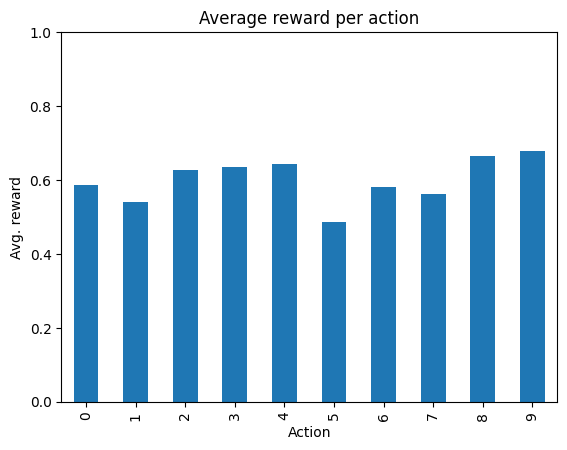

In [84]:
df.groupby('action')['reward'].mean().plot.bar(
    title="Average reward per action"
)
plt.ylim(0,1)
plt.xlabel("Action")
plt.ylabel("Avg. reward")
plt.show()

We can see that the average reward is slightly different for each arm, and an effective policy should be able to exploit the differences. 

In [128]:
# Sample synthetic logged bandit feedback
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

print(f"Bandit feedback keys: {bandit_feedback.keys()}")
print(f"Context shape: {bandit_feedback['context'].shape}")
print(f"Average reward: {bandit_feedback['reward'].mean():.4f}")
print(f"Average expected reward: {bandit_feedback['expected_reward'].mean():.4f}")

Bandit feedback keys: dict_keys(['n_rounds', 'n_actions', 'context', 'action_context', 'action', 'position', 'reward', 'expected_reward', 'pscore'])
Context shape: (10000, 5)
Average reward: 0.6002
Average expected reward: 0.6059


### Algorithms

We evaluate five contextual bandit strategies:

1. **LinUCB (α = 0.0)**  
   - _Pure greedy_ linear bandit  
   - At each round, picks the action with the highest _estimated_ reward (no confidence bonus)

2. **LinUCB (α = 0.1)**  
   - _Light‐exploration_ UCB  
   - Adds a confidence bonus to each estimated reward and always picks the action with the highest upper‐confidence bound

3. **LinUCB (α = 0.5)**  
   - _Stronger exploration_ UCB  
   - Same as above but with a larger bonus (0.5), so it explores more aggressively

4. **LinTS** (Linear Thompson Sampling)  
   - Maintains a Gaussian posterior over the linear model parameters
   - Samples a parameter vector each round and then picks the greedy action under that sample

5. **LinEpsilonGreedy (epsilon = 0.1)**  
   - Fits a linear reward model as in LinUCB.  
   - With probability 0.9 picks the arm with highest estimated reward; with probability 0.1 picks an arm uniformly at random.


In [122]:
# Define policies exactly like in the example
policies = {
    'LinUCB_0.0': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.0,  # Pure UCB
        random_state=random_state
    ),
    'LinUCB_0.1': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.1,
        random_state=random_state
    ),
    'LinUCB_0.5': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.5,
        random_state=random_state
    ),
    'LinTS': LinTS(
        dim=dim_context, 
        n_actions=n_actions, 
        random_state=random_state
    ),
    'LinEpsilonGreedy_0.1': LinEpsilonGreedy(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.1,
        random_state=random_state
    )
}

print(f"Defined {len(policies)} evaluation policies:")
for name in policies.keys():
    print(f"  - {name}")

Defined 5 evaluation policies:
  - LinUCB_0.0
  - LinUCB_0.1
  - LinUCB_0.5
  - LinTS
  - LinEpsilonGreedy_0.1


In [123]:
# We want to just make sure these are roughly the same 
print(round(bandit_feedback['pscore'].mean(),2))
print(1 /n_actions)

0.1
0.1


### Run Bandit Simulations

In [124]:
print("\nRunning bandit simulation for LinUCB_0.0...")

action_dist_linucb_00 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.0']
)

print("LinUCB_0.0 action distribution:")
print(f"  - Shape: {action_dist_linucb_00.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_00)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_00.sum(axis=1))}")


Running bandit simulation for LinUCB_0.0...


100%|██████████| 5000/5000 [00:00<00:00, 21387.53it/s]

LinUCB_0.0 action distribution:
  - Shape: (5000, 10, 1)
  - Non-zero entries: 5000
  - Rounds with actions: 5000


In [91]:
print("\nRunning bandit simulation for LinUCB_0.1...")

action_dist_linucb_01 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.1']
)

print("LinUCB_0.1 action distribution:")
print(f"  - Shape: {action_dist_linucb_01.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_01)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_01.sum(axis=1))}")


Running bandit simulation for LinUCB_0.1...


100%|██████████| 10000/10000 [00:00<00:00, 21652.76it/s]

LinUCB_0.1 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [92]:
print("\nRunning bandit simulation for LinUCB_0.5...")

action_dist_linucb_05 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.5']
)

print("LinUCB_0.5 action distribution:")
print(f"  - Shape: {action_dist_linucb_05.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_05)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_05.sum(axis=1))}")



Running bandit simulation for LinUCB_0.5...


100%|██████████| 10000/10000 [00:00<00:00, 21270.57it/s]

LinUCB_0.5 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [93]:
print("\nRunning bandit simulation for LinTS...")

action_dist_lints = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinTS']
)

print("LinTS action distribution:")
print(f"  - Shape: {action_dist_lints.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_lints)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_lints.sum(axis=1))}")



Running bandit simulation for LinTS...


100%|██████████| 10000/10000 [00:03<00:00, 3259.58it/s]


LinTS action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [94]:
print("\nRunning bandit simulation for LinEpsilonGreedy_0.1...")

action_dist_lineps = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinEpsilonGreedy_0.1']
)

print("LinEpsilonGreedy_0.1 action distribution:")
print(f"  - Shape: {action_dist_lineps.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_lineps)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_lineps.sum(axis=1))}")


Running bandit simulation for LinEpsilonGreedy_0.1...


100%|██████████| 10000/10000 [00:00<00:00, 37674.18it/s]

LinEpsilonGreedy_0.1 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [95]:
action_distributions = {
    'LinUCB_0.0': action_dist_linucb_00,
    'LinUCB_0.1': action_dist_linucb_01,
    'LinUCB_0.5': action_dist_linucb_05,
    'LinTS': action_dist_lints,
    'LinEpsilonGreedy_0.1': action_dist_lineps
}

print("\nAction distributions summary:")
for name, dist in action_distributions.items():
    active_rounds = np.count_nonzero(dist.sum(axis=1))
    print(f"  - {name}: {active_rounds}/{n_rounds} active rounds")



Action distributions summary:
  - LinUCB_0.0: 10000/10000 active rounds
  - LinUCB_0.1: 10000/10000 active rounds
  - LinUCB_0.5: 10000/10000 active rounds
  - LinTS: 10000/10000 active rounds
  - LinEpsilonGreedy_0.1: 10000/10000 active rounds


### Calculate ground truth values 

In real-world datasets, we would not know the actual ground truth, however using the synthetically created bandit algorithm, we can calculate for each policy, how would the reward be for this specfic action-context pair that our policy chooses, and hence calculate the cumulative reward for each policy

In [51]:
ground_truth_values = {}

for policy_name, policy in policies.items():
    print(f"Computing ground truth for {policy_name}...")
    
    ground_truth_policy_value = calc_ground_truth_policy_value(
        bandit_feedback=bandit_feedback,
        reward_sampler=dataset.sample_reward,  # the true reward function
        policy=policy,
        n_sim=n_sim  # number of simulations - changed this to 50 cause before we got too varying estimates 
    )
    
    ground_truth_values[policy_name] = ground_truth_policy_value
    print(f"  Ground truth value: {ground_truth_policy_value:.4f}")

print("\nGround truth ranking:")
sorted_policies = sorted(ground_truth_values.items(), key=lambda x: x[1], reverse=True)
for i, (policy_name, value) in enumerate(sorted_policies, 1):
    print(f"  {i}. {policy_name}: {value:.4f}")


Computing ground truth for LinUCB_0.0...


100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


  Ground truth value: 0.7097
Computing ground truth for LinUCB_0.1...


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


  Ground truth value: 0.7418
Computing ground truth for LinUCB_0.5...


100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


  Ground truth value: 0.7130
Computing ground truth for LinTS...


100%|██████████| 50/50 [03:52<00:00,  4.66s/it]


  Ground truth value: 0.7260
Computing ground truth for LinEpsilonGreedy_0.1...


100%|██████████| 50/50 [01:24<00:00,  1.68s/it]

  Ground truth value: 0.7146

Ground truth ranking:
  1. LinUCB_0.1: 0.7418
  2. LinTS: 0.7260
  3. LinEpsilonGreedy_0.1: 0.7146
  4. LinUCB_0.5: 0.7130
  5. LinUCB_0.0: 0.7097


### Off-Policy Evaluation Replay Method & Doubly Robust Estimator 

In this section we assess how each policy would have performed on our logged data without running it live. We use two different off-policy evaluation estimators to obtain robust, unbiased estimates of each policy's expected reward. We compare these estimates to the random baseline to understand relative performance across different contextual bandit policies

In [ ]:
# Could try others too
from obp.ope import OffPolicyEvaluation, ReplayMethod, DoublyRobust

When we get the expected reward it gets output in the shape (T,K) but we need (T,K,1) to match with the action distribution vector.

In [138]:
# shape fix function
def fix_shapes(action_dist, Q_hat):
    """Ensure action_dist and Q_hat have compatible shapes for OBP"""
    if len(action_dist.shape) == 3 and action_dist.shape[2] == 1:
        # If action_dist is (T, K, 1), expand Q_hat to match
        return action_dist, np.expand_dims(Q_hat, axis=2)

In [139]:
# Get the expected rewards and create evaluator
Q_hat = bandit_feedback['expected_reward']
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod(), DoublyRobust()]
)

# Evaluate all policies
results = {}
print("Policy Evaluation Results:")
print("-" * 50)

for name, action_dist in action_distributions.items():
    # Fix shapes automatically
    action_dist_fixed, Q_hat_fixed = fix_shapes(action_dist, Q_hat)
    
    # Evaluate policy
    estimates = ope.estimate_policy_values(
        action_dist=action_dist_fixed,
        estimated_rewards_by_reg_model=Q_hat_fixed
    )
    
    results[name] = estimates
    print(f"{name:20} | Replay: {estimates['rm']:.4f} | DR: {estimates['dr']:.4f}")

# Summary
baseline = bandit_feedback['reward'].mean()
best_policy = max(results.keys(), key=lambda x: results[x]['dr'])

print(f"\nBaseline (Random):      {baseline:.4f}")
print(f"Best Policy:            {best_policy} (DR: {results[best_policy]['dr']:.4f})")
print(f"Improvement:            {((results[best_policy]['dr'] / baseline) - 1) * 100:.1f}%")

Policy Evaluation Results:
--------------------------------------------------
LinUCB_0.0           | Replay: 0.6255 | DR: 0.6273
LinUCB_0.1           | Replay: 0.6204 | DR: 0.6297
LinUCB_0.5           | Replay: 0.5935 | DR: 0.5966
LinTS                | Replay: 0.5966 | DR: 0.6097
LinEpsilonGreedy_0.1 | Replay: 0.6283 | DR: 0.6231

Baseline (Random):      0.6002
Best Policy:            LinUCB_0.1 (DR: 0.6297)
Improvement:            4.9%


### Online Policy 

In [150]:
def create_policy(policy_name):
    """Factory function to create policies"""
    if 'LinUCB' in policy_name:
        if '0.0' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.0, random_state=random_state)
        elif '0.1' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
        elif '0.5' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.5, random_state=random_state)
    elif 'LinTS' in policy_name:
        return LinTS(dim=dim_context, n_actions=n_actions, random_state=random_state)
    elif 'LinEpsilonGreedy' in policy_name:
        return LinEpsilonGreedy(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
    else:
        raise ValueError(f"Unknown policy: {policy_name}")

def simulate_learning(bandit_feedback, policy_name):
    """Simulate policy learning"""
    n_rounds = bandit_feedback['n_rounds']
    contexts = bandit_feedback['context']
    cumulative_rewards = np.zeros(n_rounds)
    
    # Create fresh policy
    policy = create_policy(policy_name)
    
    # Run simulation
    for t in range(n_rounds):
        context = contexts[t:t+1]
        action = policy.select_action(context)[0]
        reward = dataset.sample_reward(context, np.array([action]))[0]
        
        # Update policy
        policy.update_params(action=action, reward=reward, context=context)
        
        # Track cumulative reward
        cumulative_rewards[t] = cumulative_rewards[t-1] + reward if t > 0 else reward
    
    return cumulative_rewards

In [151]:
policy_names = list(action_distributions.keys())

print("Simulating learning for all policies...")
learning_curves = {}
for name in policy_names:
    print(f"  {name}...")
    learning_curves[name] = simulate_learning(bandit_feedback, name)

print("\nFinal performance (average reward per round):")
for name, rewards in learning_curves.items():
    avg_reward = rewards[-1] / len(rewards)  # More robust than using n_rounds
    print(f"{name:20}: {avg_reward:.4f}")

Simulating learning for all policies...
  LinUCB_0.0...
  LinUCB_0.1...
  LinUCB_0.5...
  LinTS...
  LinEpsilonGreedy_0.1...

Final performance (average reward per round):
LinUCB_0.0          : 0.6993
LinUCB_0.1          : 0.7047
LinUCB_0.5          : 0.6984
LinTS               : 0.7007
LinEpsilonGreedy_0.1: 0.7175


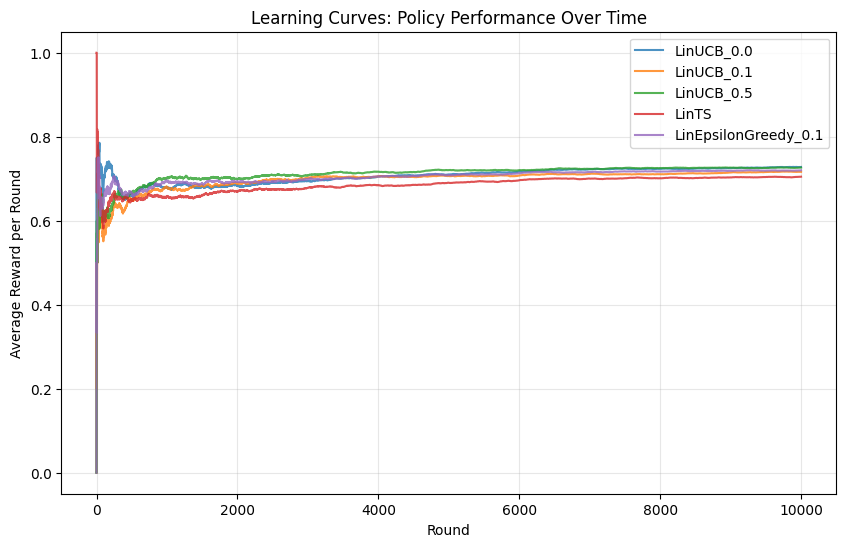

In [143]:
plt.figure(figsize=(10, 6))
for name, rewards in learning_curves.items():
    # Convert cumulative to average reward per round
    avg_rewards = rewards / np.arange(1, len(rewards) + 1)
    plt.plot(avg_rewards, label=name, alpha=0.8)

plt.xlabel('Round')
plt.ylabel('Average Reward per Round')
plt.title('Learning Curves: Policy Performance Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [144]:
# Color scheme 
colors = {
    'LinUCB_0.0': '#1f77b4',      # Blue
    'LinUCB_0.1': '#ff7f0e',      # Orange  
    'LinUCB_0.5': '#2ca02c',      # Green
    'LinTS': '#d62728',           # Red
    'LinEpsilonGreedy_0.1': '#9467bd'  # Purple
}

policy_names = list(policies.keys())

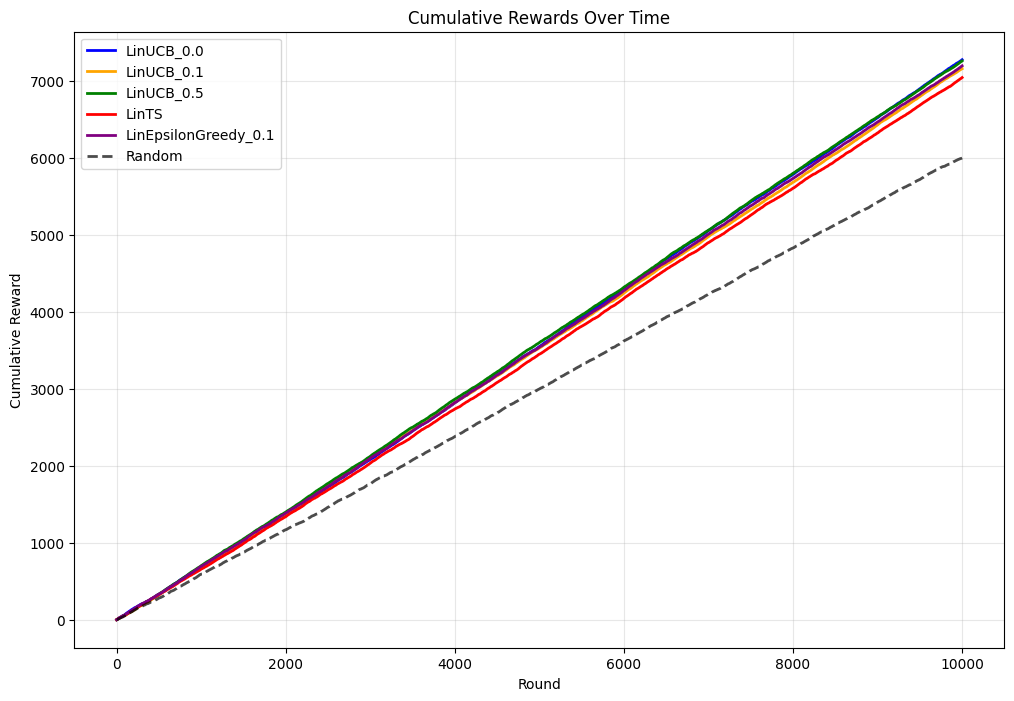

In [145]:
# Plot 1: Cumulative Rewards
plt.figure(figsize=(12, 8))
rounds = np.arange(1, n_rounds + 1)

colors = {'LinUCB_0.0': 'blue', 'LinUCB_0.1': 'orange', 'LinUCB_0.5': 'green', 
          'LinTS': 'red', 'LinEpsilonGreedy_0.1': 'purple'}

for name, rewards in learning_curves.items():
    plt.plot(rounds, rewards, label=name, color=colors[name], linewidth=2)

plt.plot(rounds, np.cumsum(bandit_feedback['reward']), '--', 
         color='black', alpha=0.7, label='Random', linewidth=2)

plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

From the cumulative reward plot, we can see that all policies outperform the random policy, with LinUCB(epsilon=0) performing the best, and LinTS performing the worst. 

Unsure if these results are expected... 

To understand to what extent the algorithms are learning over time 

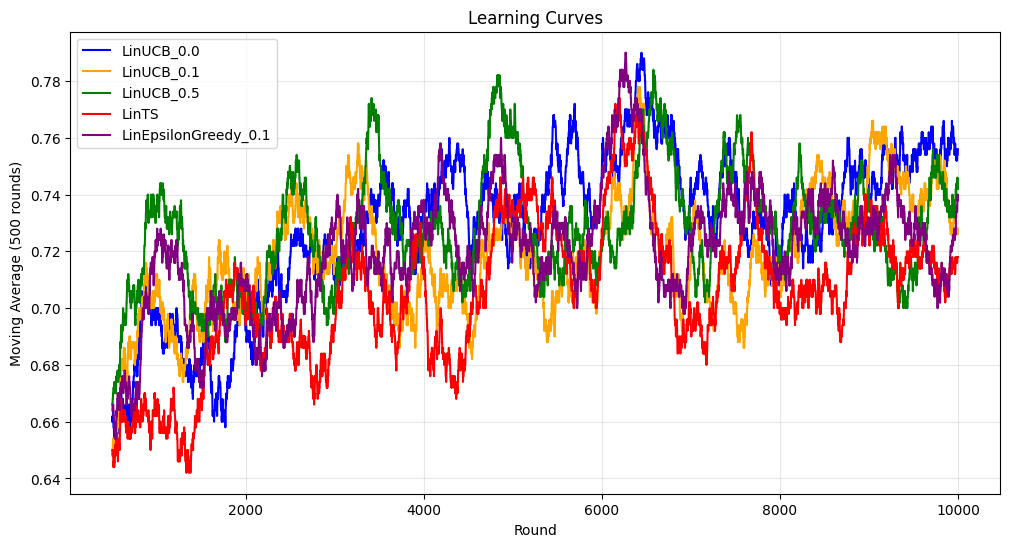

In [146]:
plt.figure(figsize=(12, 6))
window = 500

for name, cumulative in learning_curves.items():
    rewards = np.diff(np.concatenate([[0], cumulative]))
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    x = np.arange(window, len(rewards) + 1)
    plt.plot(x, moving_avg, label=name, color=colors[name])

plt.xlabel('Round')
plt.ylabel(f'Moving Average ({window} rounds)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Insights**

- Everything is super similar?? 
- 
- 

We can also plot the overall comparison between the methods on average reward. 

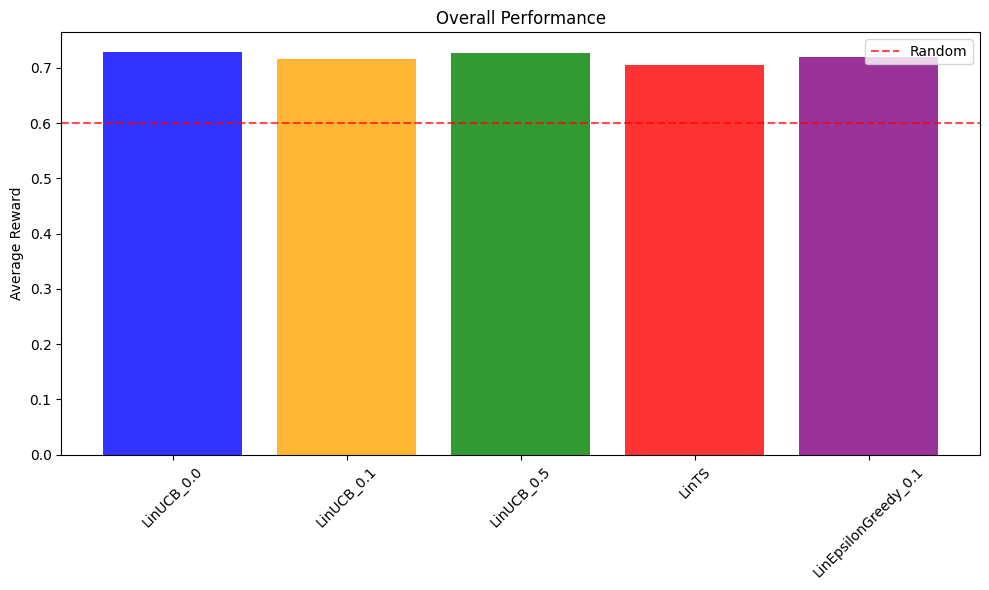

In [147]:
plt.figure(figsize=(10, 6))
names = list(learning_curves.keys())
final_rewards = [learning_curves[name][-1]/n_rounds for name in names]

plt.bar(names, final_rewards, color=[colors[name] for name in names], alpha=0.8)
plt.axhline(y=bandit_feedback['reward'].mean(), color='red', linestyle='--', 
            alpha=0.7, label='Random')
plt.ylabel('Average Reward')
plt.title('Overall Performance')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Pretty surprised that everything is just doing the same thing 

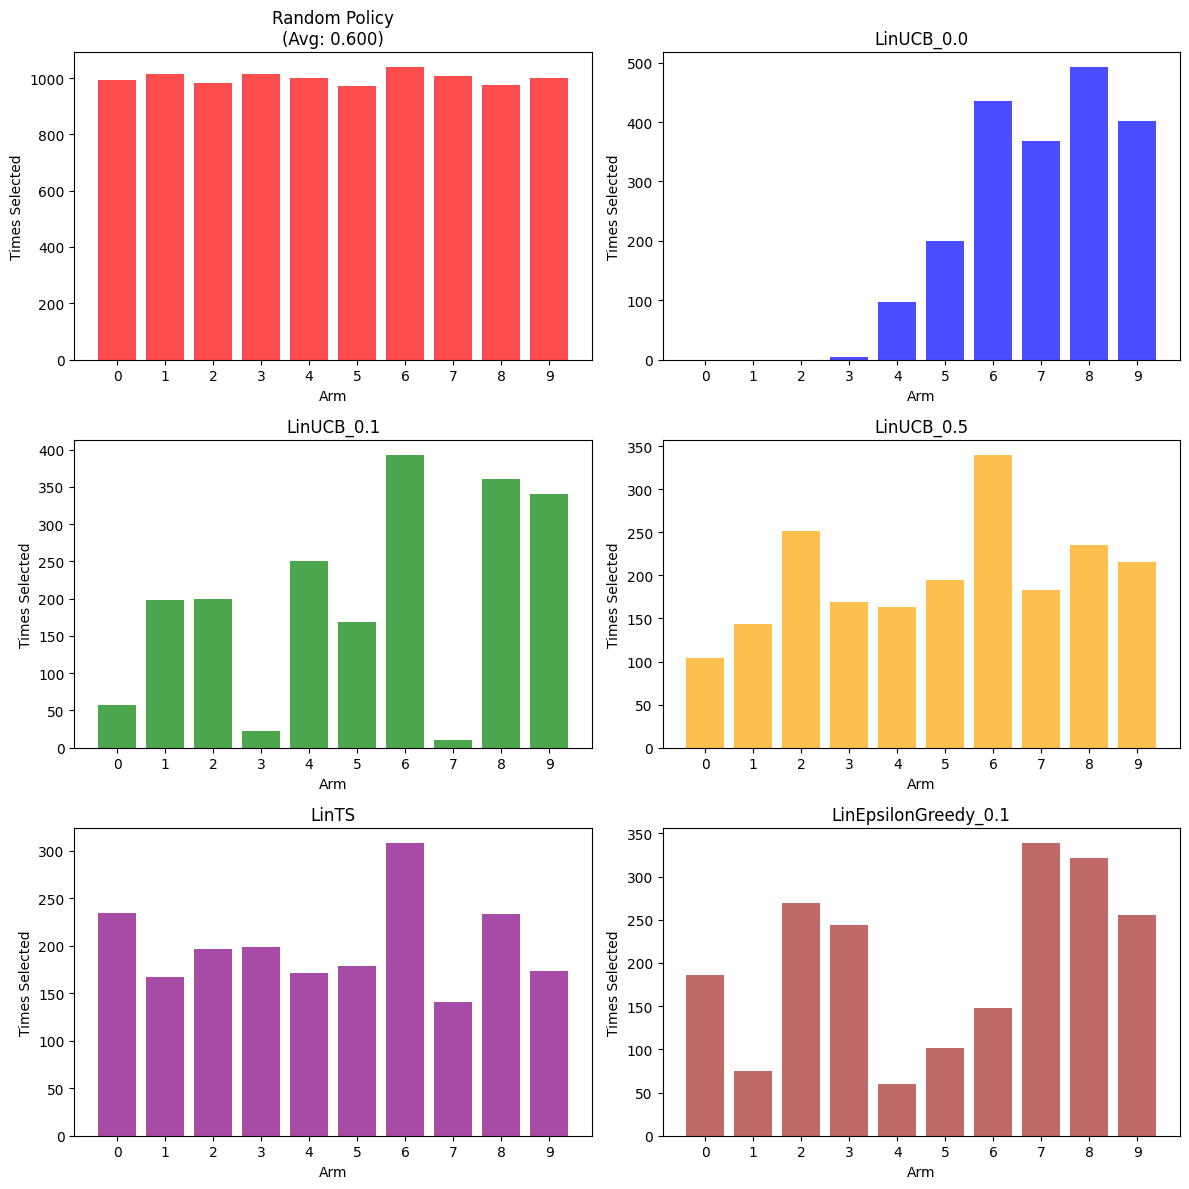

In [164]:
from collections import Counter

# Get random policy data
logged_actions = bandit_feedback['action']
logged_counts = Counter(logged_actions)

# Quick sim for ALL learning policies
policy_data = {}
for policy_name in list(action_distributions.keys()): 
    policy = create_policy(policy_name)
    actions = []
    
    for t in range(2000):  
        context = bandit_feedback['context'][t:t+1]
        action = policy.select_action(context)[0]
        reward = dataset.sample_reward(context, np.array([action]))[0]
        actions.append(action)
        policy.update_params(action, reward, context)
    
    policy_data[policy_name] = Counter(actions)

# Plot all together (1 random + all learning policies)
n_policies = len(policy_data) + 1
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Random policy
arms = range(10)
counts = [logged_counts.get(arm, 0) for arm in arms]
axes[0].bar(arms, counts, alpha=0.7, color='red')
axes[0].set_title(f'Random Policy\n(Avg: {bandit_feedback["reward"].mean():.3f})')

# All learning policies
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for i, (name, counter) in enumerate(policy_data.items()):
    counts = [counter.get(arm, 0) for arm in arms]
    axes[i+1].bar(arms, counts, alpha=0.7, color=colors[i % len(colors)])
    axes[i+1].set_title(f'{name}')

for ax in axes:
    ax.set_xlabel('Arm')
    ax.set_ylabel('Times Selected')
    ax.set_xticks(arms)

plt.tight_layout()
plt.show()